# I. VAE for the liquor dataset

dataset: vintage_spi   
original x range : 5924. Using the first 3400 (0 - 100).   
x unit: m/z  

X.shape (3553, 3400)  y.shape (3553,)


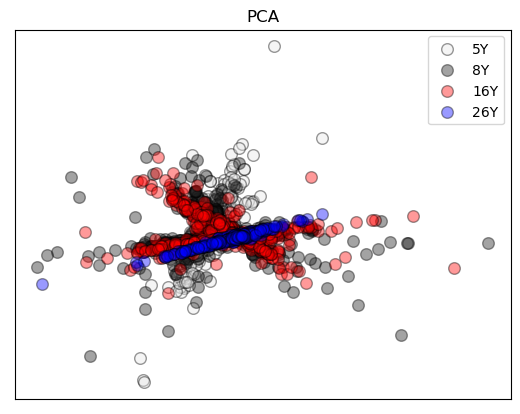

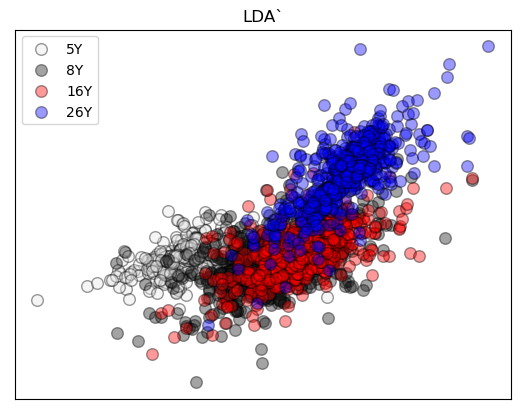

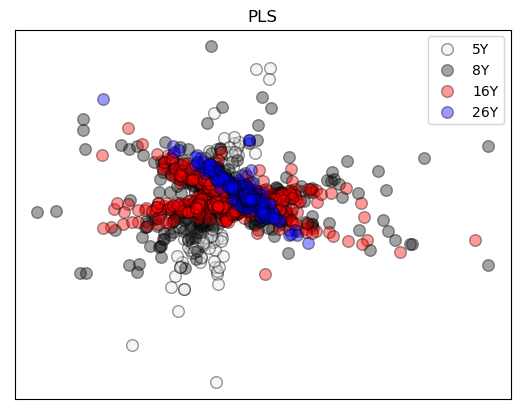

In [1]:
from qsi import io
import numpy as np

X, y, X_names, labels = io.open_dataset('7345X1.5.csv', delimiter=',', has_y=True, labels = ["5Y","8Y","16Y","26Y"])
io.scatter_plot(X, y, labels = labels)

In [2]:
from qsi import io
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler() # MinMaxScaler() # StandardScaler()
X = scaler.fit_transform(X)

In [3]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True) # , random_state=0

n = X.shape[1] # 3400

# Setting batch size
bs = 64

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=True)

In [4]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # Defining the encoder architecture
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # Defining the decoder architecture
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        # Defining the encoder forward pass
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # Returning (mu, log_var)
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # Returning z sample
        
    def decoder(self, z):
        # Defining the decoder forward pass
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        # Defining the global forward pass
        mu, log_var = self.encoder(x.view(-1, n))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# Building model
# Sizes for the hidden layers are identical to those in the paper

vae = VAE(x_dim=n, h_dim1=200, h_dim2=200, z_dim=20)
if torch.cuda.is_available():
    vae.cuda()

**Computing the loss**:  

 `recon_error + KL` 

In [5]:
optimizer = optim.Adam(vae.parameters())
# Defining loss as reconstruction error + KL divergence 
def loss_function(recon_x, x, mu, log_var):
    recon_error = F.binary_cross_entropy(recon_x, x.view(-1, n), reduction='sum')
    KL = 0.5 * torch.sum(log_var.exp() - log_var + mu.pow(2) - 1)
    return recon_error + KL

In [6]:
# Training loop
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):  # Generating batch
        data = data.float().cuda()
        optimizer.zero_grad()  # Telling Pytorch not to store gradients between backward passes
        
        recon_batch, mu, log_var = vae(data) # Forward pass
        loss = loss_function(recon_batch, data, mu, log_var)  # Computing loss
        
        loss.backward()  # Performing automatic differentiation w.r.t weights of the networks
        train_loss += loss.item()  # Updating loss value
        optimizer.step()  # Performing parameters update using gradients computed with .backward()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
            
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [7]:
# Computing loss on the test set
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.float().cuda()
            recon, mu, log_var = vae(data)
            
            # Adding batch loss to accumulator
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)  # Normalizing with number of samples in the test set
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [8]:
# Training the VAE for N epochs
for epoch in range(1, 30):
    train(epoch)
    test()

Train Epoch: 1 [0/2842 (0%)]	Loss: 2357.492920
====> Epoch: 1 Average loss: 572.6525
====> Test set loss: -10.3616
Train Epoch: 2 [0/2842 (0%)]	Loss: -20.072094
====> Epoch: 2 Average loss: -52.8044
====> Test set loss: -135.2786
Train Epoch: 3 [0/2842 (0%)]	Loss: -165.905594
====> Epoch: 3 Average loss: -179.1012
====> Test set loss: -181.0208
Train Epoch: 4 [0/2842 (0%)]	Loss: -161.319122
====> Epoch: 4 Average loss: -213.3462
====> Test set loss: -242.9144
Train Epoch: 5 [0/2842 (0%)]	Loss: -166.794571
====> Epoch: 5 Average loss: -334.1163
====> Test set loss: -486.8667
Train Epoch: 6 [0/2842 (0%)]	Loss: -561.028625
====> Epoch: 6 Average loss: -632.9589
====> Test set loss: -682.2522
Train Epoch: 7 [0/2842 (0%)]	Loss: -732.887451
====> Epoch: 7 Average loss: -758.1061
====> Test set loss: -756.8707
Train Epoch: 8 [0/2842 (0%)]	Loss: -585.612488
====> Epoch: 8 Average loss: -821.7218
====> Test set loss: -830.1469
Train Epoch: 9 [0/2842 (0%)]	Loss: -884.038513
====> Epoch: 9 Averag

***

Evaluating the output of the decoder on $64$ random $z$'s.

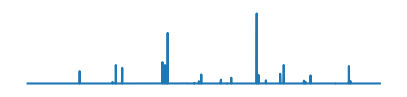

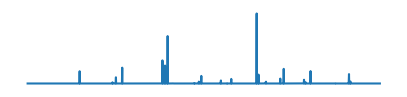

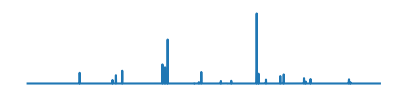

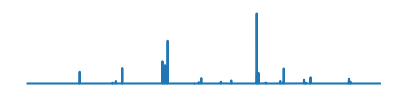

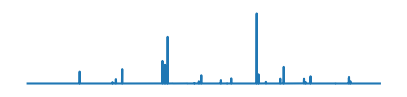

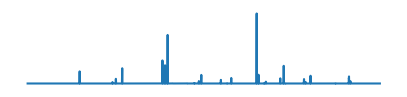

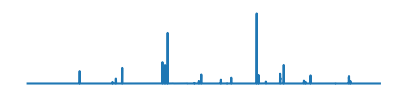

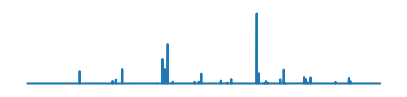

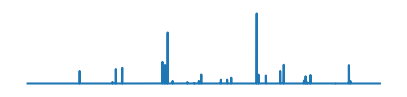

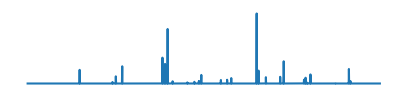

In [9]:
def show(X):
    X = X.squeeze().cpu().numpy()
    # print(X.shape)
    X = scaler.inverse_transform(X) # NOTE: remember to reverse scaling
    for x in X:
        plt.figure(figsize = (5,1))
        plt.plot(x.T)
        plt.axis('off')
        plt.show()
    
with torch.no_grad():
    z = torch.randn(10, 20).cuda()  # Generating 64 random z in the representation space
    sample = vae.decoder(z).cuda()  # Evaluating the decoder on each of them
    show(make_grid(sample.view(10, 1, n), padding=0))  # Plotting the resulting images

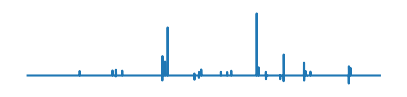

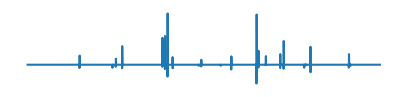

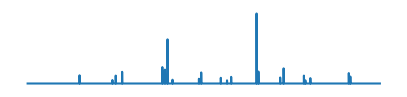

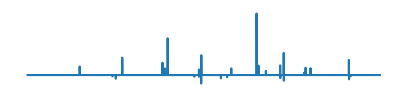

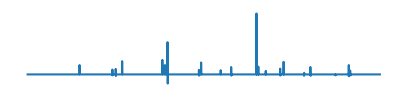

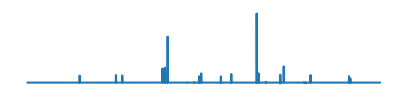

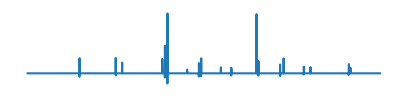

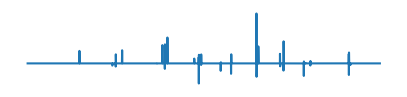

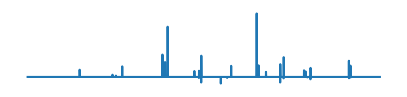

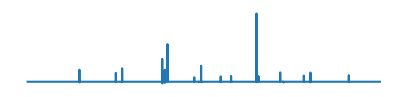

In [10]:
for x in scaler.inverse_transform( X[np.random.choice(range(len(y)), size=10, replace=False)]  ):
    plt.figure(figsize = (5,1))
    plt.plot(x.T)
    plt.axis('off')
    plt.show()

# II. Compressed sensing

## random binary sensing matrix vs. random Gaussian sensing matrix

" A sensing matrix maps input vector to measurement vector through linear wighted summation of input. What makes a specefic matrix good, is application dependent. Now, both distributions more or less satisfy RIP. However hardware implementation of the Bernoulli matrix (binary or bipolar) is much much easier especially in analog domain. A Bernoulli wight is either 0 or 1 (or -1/1 in case of polar Bernoulli), but a Gaussian wight is a floating point figure. Multiplication of a flouting point number either in digital or analog, is resource consuming, while multiplication of a Bernoulli wight is feasible through implementation of a simple switch in analog domain or and instruction in digital. "

## a) Using VAEs

Sampling
$$ xs = \Phi x ,\quad for \quad \Phi_{k*N}, k > （4 * non-sparsity） $$

Sparsity hypothesis
$$ x = \Psi z $$

Compressed Sensing
$$ x_s = \Phi \Psi z $$

Optimization (LASSO)
$$ minimize \quad  ||z||_1 $$
$$ s.t \quad     x_s = \Phi \Psi z $$

Reconstruction
$$ x = \Psi z $$

The function `vae_reconstruct()` defined below solves the problem $$\operatorname{argmin}_z \|AG(z)-y\|^2 重建误差 $$


where:  
* G(z)是解码器, G相当于变换基 Ψ, G(z)即Xr
* $x^*\in \mathbb R^n$ is an input image. 输入图像 X
* $A$ is an $m\times n$ matrix with i.i.d $\mathcal N(0,\frac 1m)$ entries. 感知矩阵 Φ
* $\eta \in \mathbb R^m$ is a random Gaussian noise with i.i.d $\mathcal N(0,\frac{0.1}{\sqrt m})$ entries.
* $y = Ax^* + \eta$ is the measurement vector. 即xs + noise

We follow the same exact procedure as in the paper: sample $10$ random initial $z$'s and solve the problem for each initialization using Adam optimizer with learning rate $0.01$. Gradients are computed automatically using Pytorch's `autograd` library. We return the $z$ that yields lowest measurement error at the end.

Adding `requires_grad_(False)` on all the variables except `z` ensures that only `z` is being optimized on.

In [11]:
def vae_reconstruct(A, y, regularization=0.1):
    z_best = torch.randn(1, 20).cuda()
    z_best.requires_grad_(False)
    
    for _ in range(10):  # Performing 10 random restarts, i.e. repeat for 10 initial random z's
        z = torch.randn(1, 20).cuda()
        z.requires_grad_(True)
        
        optimizer = optim.Adam([z], lr = 0.01)  # Using same optimizer configuration as in the paper
                                                # Only parameter for optimization is z
        for _ in range(1000):  # Performing 1000 gradient steps, as in the paper
            AG_z = torch.mm(A,vae.decoder(z).view(-1,1).cuda())  # Computing AG(z)
            if regularization is not None:
                loss = torch.pow(torch.norm(AG_z - y), 2) + regularization * torch.pow(torch.norm(z),2) # 正则化，抑制z向量
            else:
                loss = torch.pow(torch.norm(AG_z - y), 2)
            optimizer.zero_grad()
            loss.backward()  # Using automatic differentiation on the loss
            optimizer.step()
        sample = vae.decoder(z).cuda()
        with torch.no_grad():
            if loss < torch.pow(torch.norm(torch.mm(A,vae.decoder(z_best).view(-1,1).cuda())-y),2):
                z_best = z  # Keeping z with smallest measurement error
                
    return z_best

`vae_reconstruct()` 求解自编码器隐空间中的最优z

The function `vae_cs()` defined below takes as input an image vector `x_star`, generates `A` and the measurement `y`, and reconstructs the image using `vae_reconstruct()`.

In [12]:
import random

m = round( n * 0.1) # 10%

def vae_cs(m, n, x_star, regularization=0.1, add_noise = True):
    
    x_star = x_star.float()
    
    ######### Sensing matrix from Normal dist ############
    
    normal = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0/m])) # 构造N(0, 1/m)的感知矩阵
    A = normal.sample((m,n)).squeeze().cuda() # squeeze对数据的维度进行压缩，去掉维数为1的的维度，默认是将所有为1的维度删掉
    
    ######### Sensing matrix using the identity matrix ########### 
    
    # IDX = random.sample(range(n), m)
    # A = torch.Tensor( np.eye(n)[IDX] ).cuda().float()
    
    ####################
    
    A.requires_grad_(False)
    
    normal = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([0.1/np.sqrt(m)]))
    noise = normal.sample((m,)).cuda() # 白噪声
    noise.requires_grad_(False)
    
    if add_noise:
        y = torch.mm(A,x_star) + noise # 相当于采用后得到的xs
    else:
        y = torch.mm(A,x_star)
    y.cuda()
    y.requires_grad_(False)
    
    z = vae_reconstruct(A, y, regularization) # 依据Xs求解z
    return vae.decoder(z).view(n,1).detach().cpu().numpy() # 利用decoder获取Xr

The code below generates reconstructions for every class. One test sample per class.

In [13]:
labels = []
images = []

for (image, label) in test_dataset:
    if label not in labels:
        labels.append(label)
        images.append(image)
        
outputs_noreg = [vae_cs(m, n, x_star.view(n,1).cuda(), None, True) for x_star in images]
outputs_reg = [vae_cs(m, n, x_star.view(n,1).cuda(), 0.5, True) for x_star in images]
# w/o noise
# with noise
# Gaussian sensing
# Bernoulli sensing

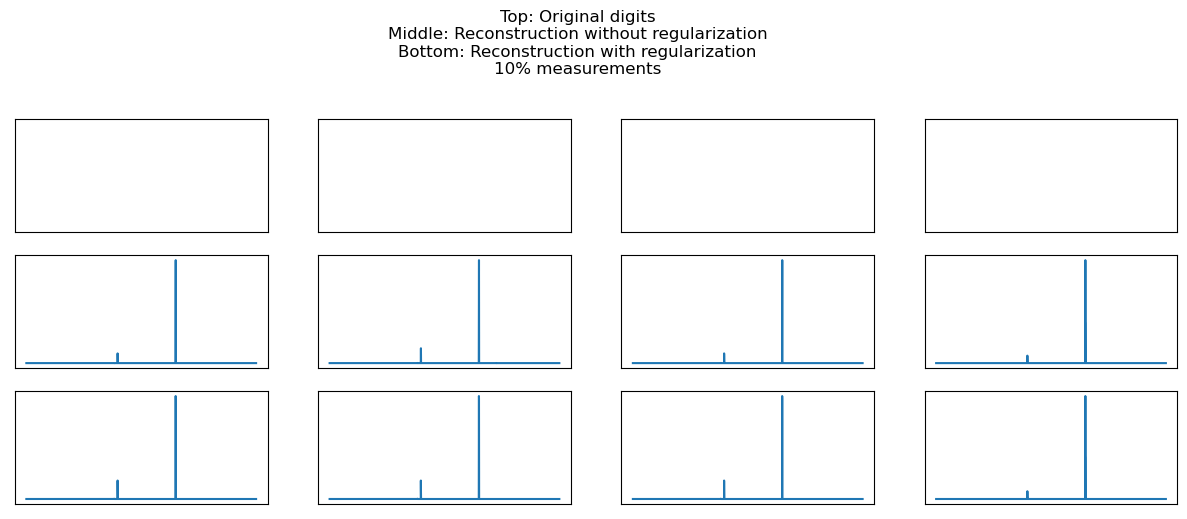

In [28]:
outputs_noreg = scaler.inverse_transform( np.squeeze(np.array(outputs_noreg)) )
outputs_reg = scaler.inverse_transform( np.squeeze(np.array(outputs_reg)) )

fig, ax = plt.subplots(3, 4, figsize=(15,5))
for j in range(4):
    ax[0,j].plot(scaler.inverse_transform( images[j].view(1,n).cpu().numpy()  ) ) 
    ax[1,j].plot(outputs_noreg[j] )
    ax[2,j].plot(outputs_reg[j] )
    ax[0,j].set_xticks([])
    ax[0,j].set_yticks([])
    ax[1,j].set_xticks([])
    ax[1,j].set_yticks([])
    ax[2,j].set_xticks([])
    ax[2,j].set_yticks([])
fig.suptitle('''Top: Original digits
Middle: Reconstruction without regularization
Bottom: Reconstruction with regularization
10% measurements''', y = 1.1)
plt.show()

## Results
The method provided in the paper works as intended. The results shown above were obtained with $100$ measurements (out of the 784 of the original image).  

For the $z$ found by gradient descent, $G(z)$ is indeed a faithful reconstruction of the digit. 

By comparing the second and the third row, one notices that adding regularization (with strength 0.1 as done in the paper) **severely degrades** the quality of the reconstructions, which become quite blurry.

Below we show results with $25$ measurements.

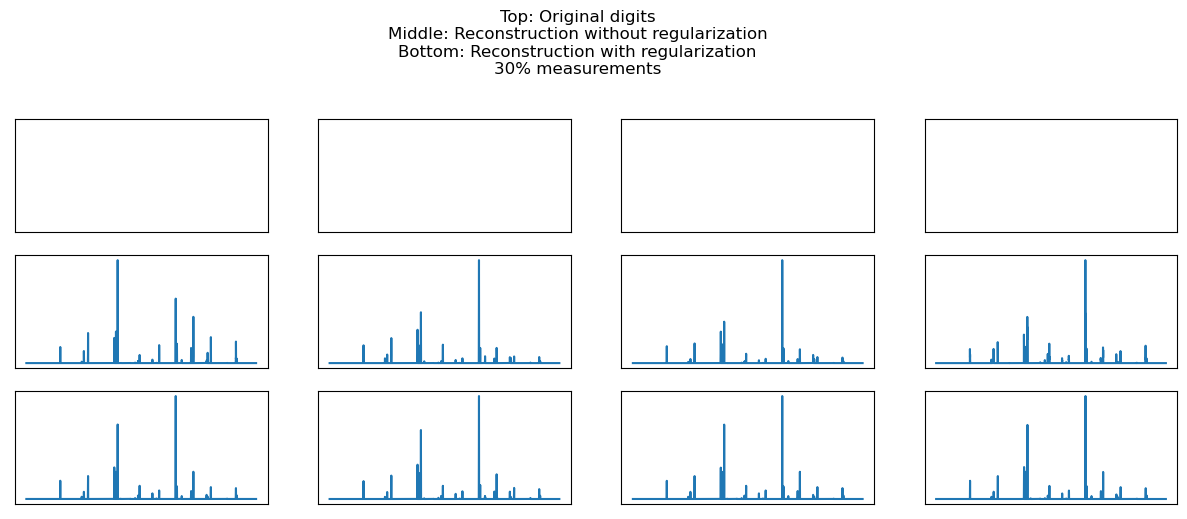

In [30]:
m = round(n * 0.3) # 30%

labels = []
images = []
for (image, label) in test_dataset:
    if label not in labels:
        labels.append(label)
        images.append(image)
outputs_noreg = [vae_cs(m, n, x_star.view(n,1).cuda(), None) for x_star in images]
outputs_reg = [vae_cs(m, n, x_star.view(n,1).cuda(), 0.2) for x_star in images]


# ------------- scaling inverse transform -----------------
# signals = scaler.inverse_transform( np.squeeze(images)) 
outputs_noreg = scaler.inverse_transform( np.squeeze(np.array(outputs_noreg)) )
outputs_reg = scaler.inverse_transform( np.squeeze(np.array(outputs_reg)) )



fig, ax = plt.subplots(3, 4, figsize=(15,5))
for j in range(4):
    ax[0,j].plot(scaler.inverse_transform( images[j].view(1,n).cpu().numpy()  ) ) 
    ax[1,j].plot(outputs_noreg[j])
    ax[2,j].plot(outputs_reg[j])
    ax[0,j].set_xticks([])
    ax[0,j].set_yticks([])
    ax[1,j].set_xticks([])
    ax[1,j].set_yticks([])
    ax[2,j].set_xticks([])
    ax[2,j].set_yticks([])
fig.suptitle('''Top: Original digits
Middle: Reconstruction without regularization
Bottom: Reconstruction with regularization
30% measurements''', y = 1.1)
plt.show()

With only $25$ measurements the reconstructions have not lost much in quality, which is quite surprising.

## b) Using basis pursuit

The function `bp_reconstruct()` defined below solves the problem $$\operatorname{argmin_x} \|x\|_1 \quad s.t. \; \; Ax=y$$

The function `bp_cs()` defined below takes as input an image vector `x_star`, generates `A` and the measurement `y`, and reconstructs the image using `bp_reconstruct()`. 

The basis pursuit minimization is a convex optimization problem that can be reformulated as a linear programming problem.

## BP 和 LASSO的区别

```

some differences between BP and Lasso can be seen when consider the different formulation of the problems.
Basis Pursuit
min∥x∥1
subject toAx=b
If you have some noise in your data,you can relax the constraint to some degree and reformulate it:
min∥x∥1
subject to∥Ax−b∥2≤ϵ
This problem is called Basis Pursuit Denoising (BPDN). For BP, b must be in the column space of A i.e. Ax=b. So, BPDN is noise tolarable version of BP.
In order to achieve Lasso formulation, Exchange the constraint and the objective of BPDN and bring the sparsity level:
min∥Ax−b∥2
min∥x∥1≤S
the above problem is called Lasso. Considering sparsity inducing nature of l1 norm, one can see from the formulation that Lasso is suitable for feature selection.
Also, there is another formulation of lasso.The l1 norm is convex, so you can relax the constraint and bring it into objective function by introducing lagrange multipliers.
min∥Ax−b∥2+λ∥x∥1
Conclusion: (refer to papers on sparsity for some of this statements)
BP is not the same as Lasso.
BP is a linear program.
BPDN/Lasso are quadratic programs.
Lasso and BPDN are equivalent problems.
```

In [39]:
m = 100

def bp_reconstruct(n, A, y): 
    ''' 
    argminx‖𝑥‖1  𝑠.𝑡.𝐴𝑥=𝑦
    '''
    
    P, q = np.array(A.cpu()), np.array(y.cpu()).astype(np.double).flatten()
    x = cvx.Variable(n)
    obj = cvx.Minimize(cvx.norm(x,1))
    const = [P @ x == q]
    prob = cvx.Problem(obj,const)
    result = prob.solve()
    return x.value

def bp_cs(m, n, x_star):
    
    normal = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0/m]))
    A = normal.sample((m,n)).squeeze().cuda()
    
    normal = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([0.1/np.sqrt(m)]))
    noise = normal.sample((m,)).cuda()

    y = torch.mm(A,x_star) + noise
    y.cuda()
    
    return bp_reconstruct(n, A, y)

In [40]:
outputs_lasso = [bp_cs(m, n, x_star.view(n,1).float().cuda()) for x_star in images]

# ------------- scaling inverse transform -----------------
outputs_lasso = scaler.inverse_transform( np.squeeze(np.array(outputs_lasso)) )

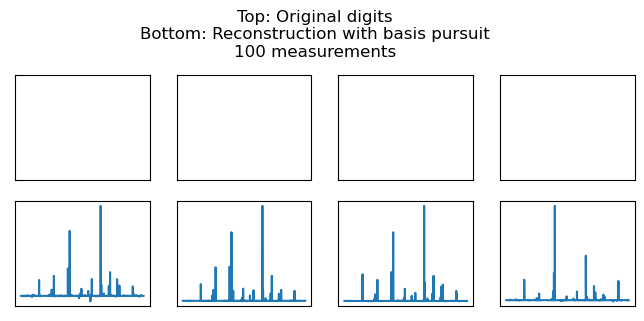

In [43]:
fig, ax = plt.subplots(2, 4, figsize=(8,3))
for j in range(4):
    ax[0,j].plot(scaler.inverse_transform( images[j].view(1,n).cpu().numpy()  ) ) 
    ax[1,j].plot(outputs_lasso[j])
    ax[0,j].set_xticks([])
    ax[0,j].set_yticks([])
    ax[1,j].set_xticks([])
    ax[1,j].set_yticks([])
fig.suptitle('''Top: Original digits
Bottom: Reconstruction with basis pursuit
100 measurements''', y = 1.1)
plt.show()

In [44]:
m = 300
outputs_lasso = [bp_cs(m, n, x_star.view(n,1).float().cuda()) for x_star in images]

# ------------- scaling inverse transform -----------------
outputs_lasso = scaler.inverse_transform( np.squeeze(np.array(outputs_lasso)) )

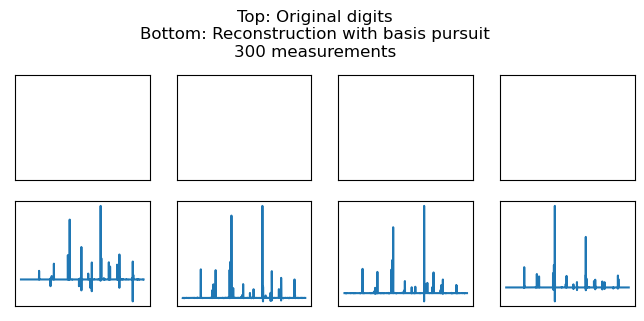

In [45]:
fig, ax = plt.subplots(2, 4, figsize=(8,3))
for j in range(4):
    ax[0,j].plot(scaler.inverse_transform( images[j].view(1,n).cpu().numpy()  ) ) 
    ax[1,j].plot(outputs_lasso[j])
    ax[0,j].set_xticks([])
    ax[0,j].set_yticks([])
    ax[1,j].set_xticks([])
    ax[1,j].set_yticks([])
fig.suptitle('''Top: Original digits
Bottom: Reconstruction with basis pursuit
300 measurements''', y = 1.1)
plt.show()

# TODO:

images = X[np.random.choice(range(len(y)), size=10, replace=False)]

Classification performance

## Results:

We show results of basis pursuit with $100$ and $300$ measurements. For $m=100$ the reconstructions are useless, and for $m=300$ they are arguable decent.

Basis pursuit compares very poorly against the VAE. **However**, one should not forget that the VAE was trained beforehand on a large relevant dataset, whereas basis pursuit works with **no prior knowledge of the data**.

# Other reconstruction algorithms: 

## MOD (Method of Optimal Directions)

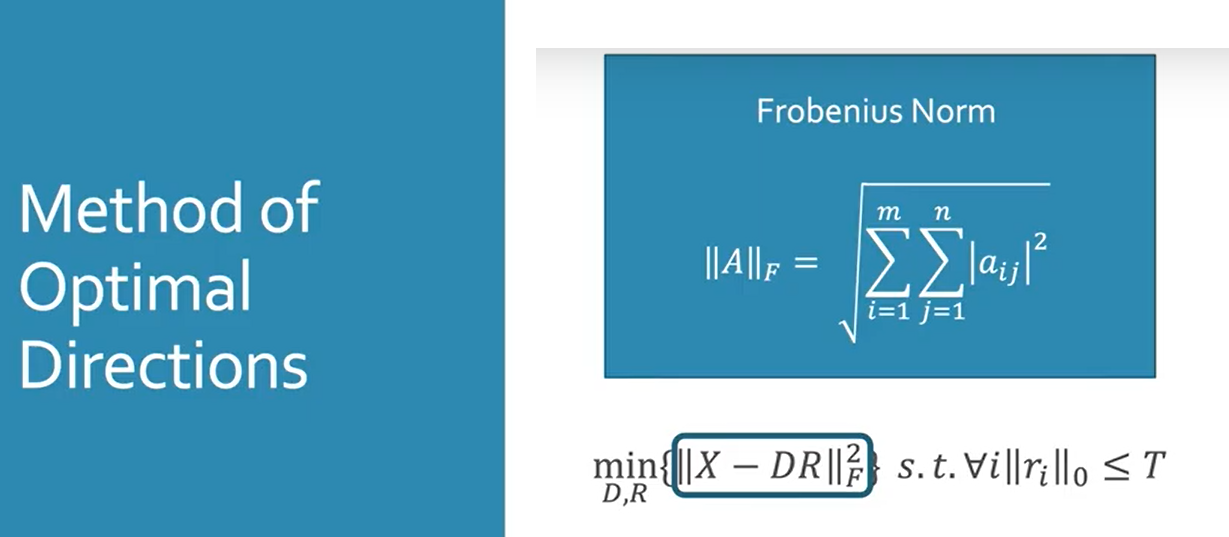

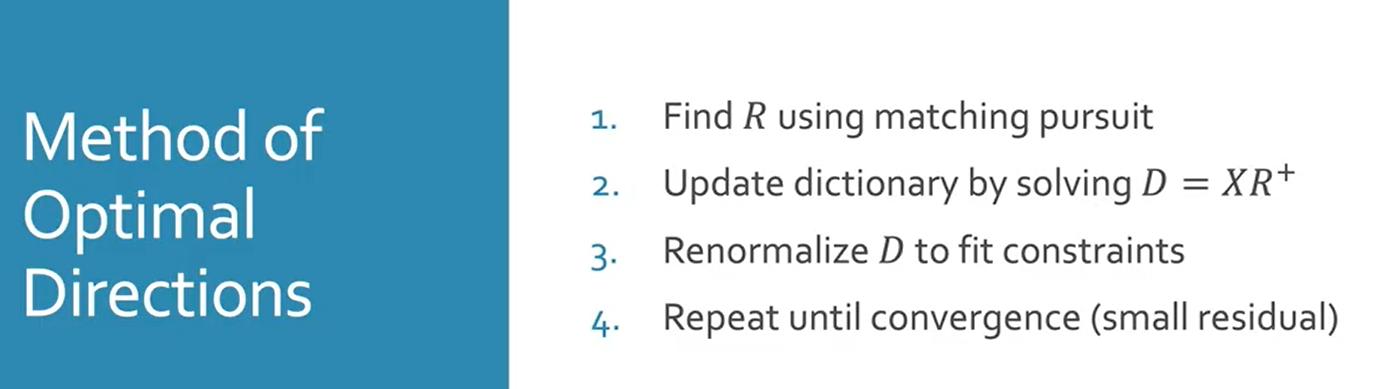

MOD uses matching pursuit. 

MP is a greedy algorithm. 

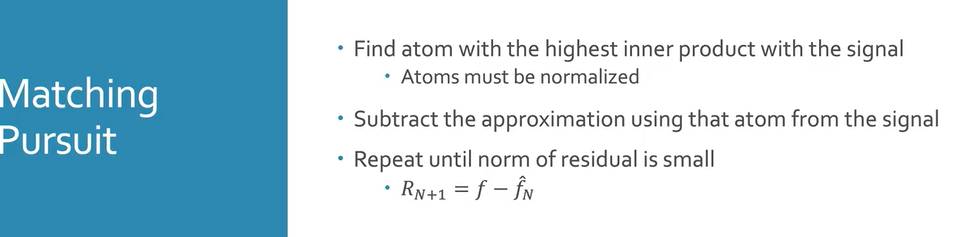

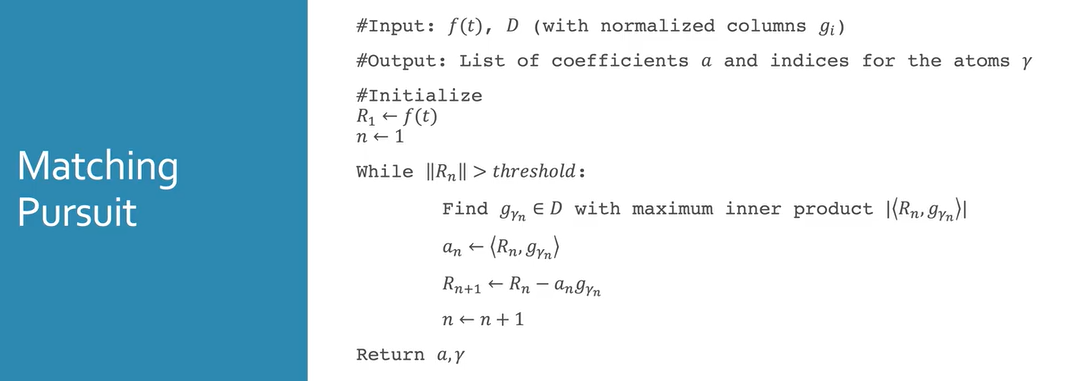

## K-SVD

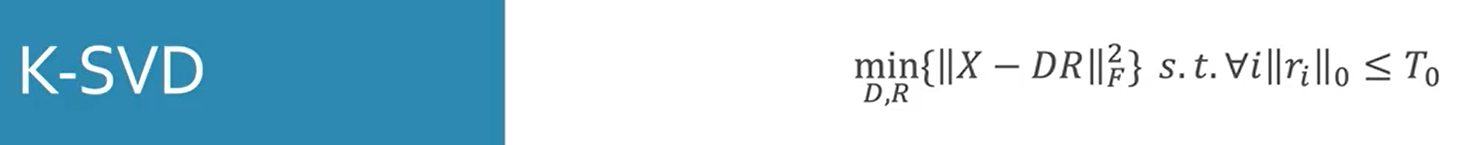 

It relaxes the K-means by allowing T0 (1 for k-means) elements to be non-zero